In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import xgboost as xgb
import lightgbm as lgb




In [324]:

# =============================
# LOAD & CLEAN DATA
# =============================
df = pd.read_csv("../data/cleaned_customer_data.csv")
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Calculate total_value if not already present
if 'total_value' not in df.columns and {'price','quantity'}.issubset(df.columns):
    df['total_value'] = df['price'] * df['quantity']

# Extract date components
df['year'] = df['sale_date'].dt.year
df['weekofyear'] = df['sale_date'].dt.isocalendar().week.astype(int)

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment'] = df['sentiment'].map(sentiment_map)

# =============================
# AGGREGATE TO PRODUCT-WEEK LEVEL
# =============================

agg_dict = {
    'quantity': 'sum',               # Target variable
    'price': 'mean',                 # Avg price per week
    'total_value': 'sum',           
    'category': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    'product_name': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    'sentiment': 'mean'             # Avg sentiment if available
}

# Add region and segment (part of grouping) to keep them after aggregation
group_cols = ['product_id', 'year', 'weekofyear', 'region', 'segment']
df_grouped = df.groupby(group_cols).agg(agg_dict).reset_index()

# =============================
# ONE-HOT ENCODING
# =============================
categoricals = [col for col in ['category', 'region', 'segment'] if col in df_grouped.columns]
df_encoded = pd.get_dummies(df_grouped, columns=categoricals, drop_first=True)

# =============================
# CREATE ORDERING COLUMN
# =============================
df_encoded['date_order'] = pd.to_datetime(df_encoded['year'].astype(str) + '-W' + df_encoded['weekofyear'].astype(str) + '-1', format='%G-W%V-%u')
df_encoded = df_encoded.sort_values('date_order').reset_index(drop=True)

# =============================
# SEPARATE FEATURES & TARGET
# =============================
X = df_encoded.drop(columns=['quantity', 'product_id', 'product_name', 'date_order','price'], errors='ignore')
y = df_encoded['quantity']

# # # Remove top/bottom 1% of sales values # 
# q_low, q_high = y.quantile([0.25, 0.75]) # 
# mask = (y > q_low) & (y < q_high) # 
# X = X[mask].reset_index(drop=True) # 
# y = y[mask].reset_index(drop=True) # 
# #dates_series = dates_series[mask].reset_index(drop=True)


# =============================
# TRAIN-TEST SPLIT
# =============================
split_point = int(0.7 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]




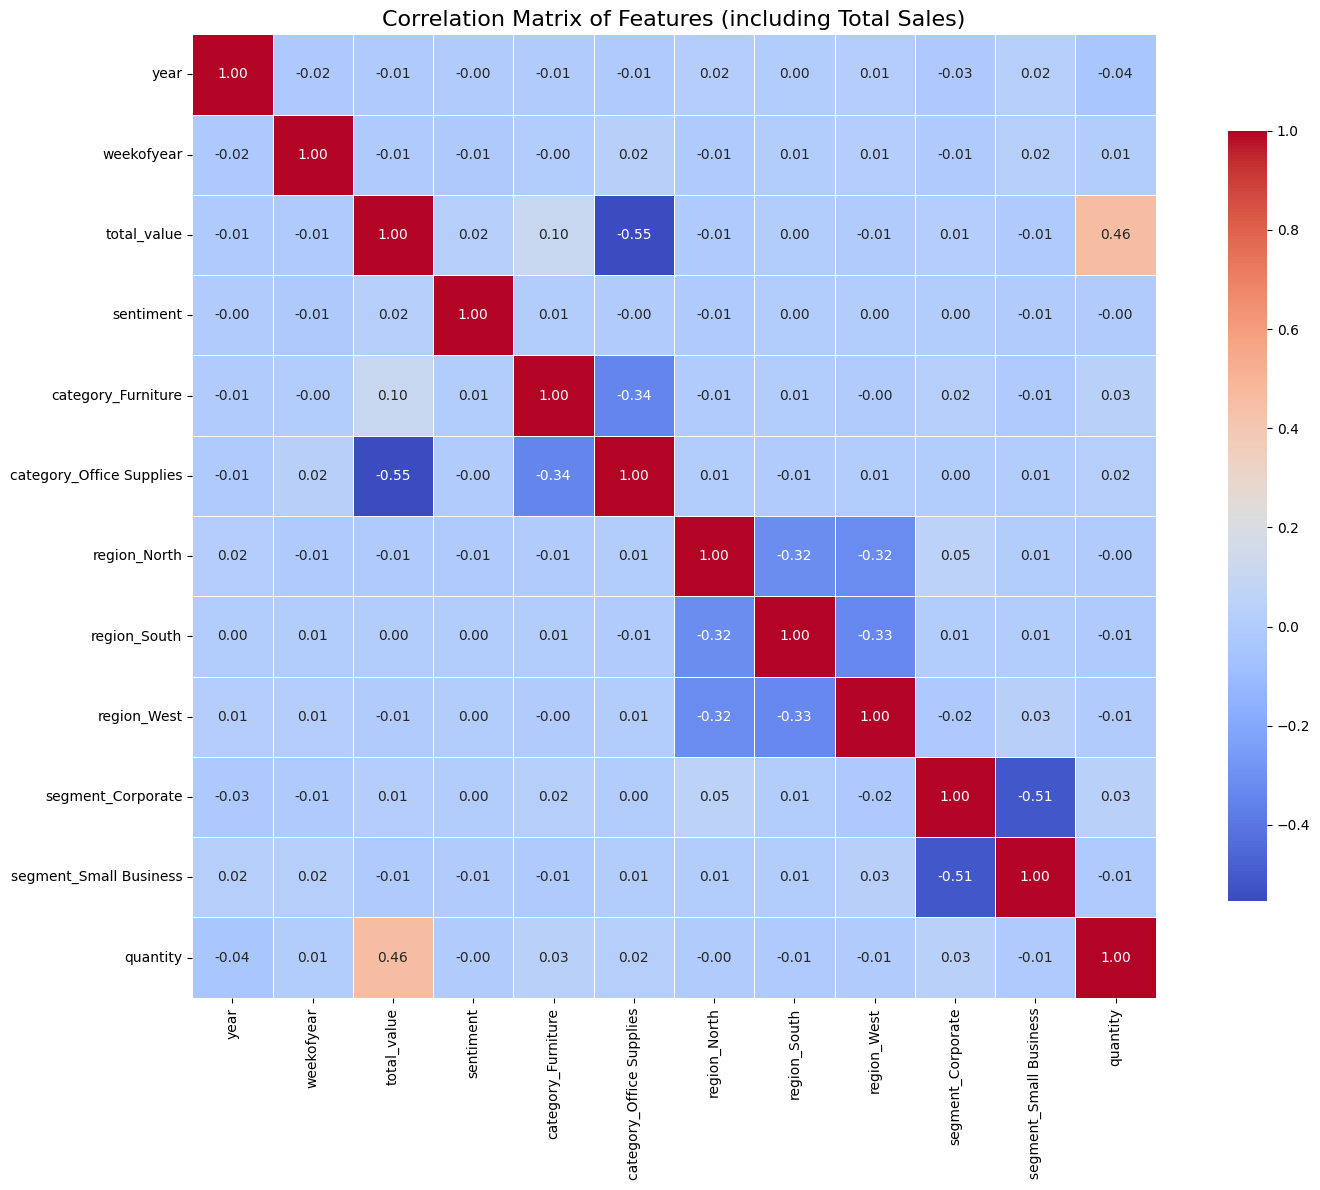

In [325]:
# Combine features and target
df_corr = pd.concat([X, y], axis=1)

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16,12))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Features (including Total Sales)", fontsize=16)
plt.tight_layout()
plt.show()

In [326]:

selector = VarianceThreshold(threshold=0.1)
X_var = selector.fit_transform(X)

# Keep only high-variance columns
X = X.loc[:, selector.get_support()]
print("Features after variance filter:", X.shape[1])

Features after variance filter: 11


In [327]:
X_test

,year,weekofyear,total_value,sentiment,category_Furniture,category_Office Supplies,region_North,region_South,region_West,segment_Corporate,segment_Small Business
3733,2022,42,24000,-1.0,False,False,False,True,False,False,False
3734,2022,42,24000,0.0,False,False,False,True,False,True,False
3735,2022,42,8000,-1.0,True,False,True,False,False,True,False
3736,2022,43,12000,1.0,False,False,False,False,True,False,False
3737,2022,43,3000,1.0,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
5328,2023,52,40000,1.0,True,False,False,False,True,False,True
5329,2023,52,50000,1.0,False,False,False,False,True,False,False
5330,2023,52,75000,1.0,False,False,False,True,False,False,True
5331,2023,52,500,0.0,False,True,False,False,True,True,False


In [328]:
# =============================
# MODEL TRAINING
# =============================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# =============================
# EVALUATION
# =============================
print("=== Product-Week Model Performance ===")
print("R2:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

# Optional: Check some predicted vs actual values
compare_df = pd.DataFrame({
    'Actual Quantity': y_test.values,
    'Predicted Quantity': y_pred
})
print(compare_df.head(10))


=== Product-Week Model Performance ===
R2: 0.3733
RMSE: 1.5177
   Actual Quantity  Predicted Quantity
0                2            2.535550
1                2            2.574731
2                1            2.416184
3                1            1.937233
4                1            1.558293
5                2            1.737501
6                3            2.923519
7                1            3.399956
8               10            2.770219
9                5            4.042946


In [329]:

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print("R²:", round(r2_score(y_test, y_pred_rf), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 4))

=== Random Forest ===
R²: 0.7946
RMSE: 0.8688


In [330]:


# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM: (samples, timesteps, features)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define RNN model
rnn_model = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, verbose=0)

y_pred_rnn = rnn_model.predict(X_test_rnn).flatten()

print("=== RNN (LSTM) ===")
print("R²:", round(r2_score(y_test, y_pred_rnn), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_rnn)), 4))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
=== RNN (LSTM) ===
R²: 0.4557
RMSE: 1.4144


In [331]:

xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost ===")
print("R²:", round(r2_score(y_test, y_pred_xgb), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 4))


=== XGBoost ===
R²: 0.7765
RMSE: 0.9063


In [332]:

lgb_model = lgb.LGBMRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("R²:", round(r2_score(y_test, y_pred_lgb), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lgb)), 4))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 3733, number of used features: 11
[LightGBM] [Info] Start training from score 3.451112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [333]:

# Store results in a dictionary
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'RNN'],
    'R2': [
        round(r2_score(y_test, y_pred), 4),
        round(r2_score(y_test, y_pred_rf), 4),
        round(r2_score(y_test, y_pred_xgb), 4),
        round(r2_score(y_test, y_pred_lgb), 4),
        round(r2_score(y_test, y_pred_rnn), 4)
    ],
    'RMSE': [
        round(np.sqrt(mean_squared_error(y_test, y_pred)), 4),
        round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 4),
        round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 4),
        round(np.sqrt(mean_squared_error(y_test, y_pred_lgb)), 4),
        round(np.sqrt(mean_squared_error(y_test, y_pred_rnn)), 4)
    ]
}

results_df = pd.DataFrame(results)
display(results_df)


,Model,R2,RMSE
0,Linear Regression,0.3733,1.5177
1,Random Forest,0.7946,0.8688
2,XGBoost,0.7765,0.9063
3,LightGBM,0.7789,0.9014
4,RNN,0.4557,1.4144


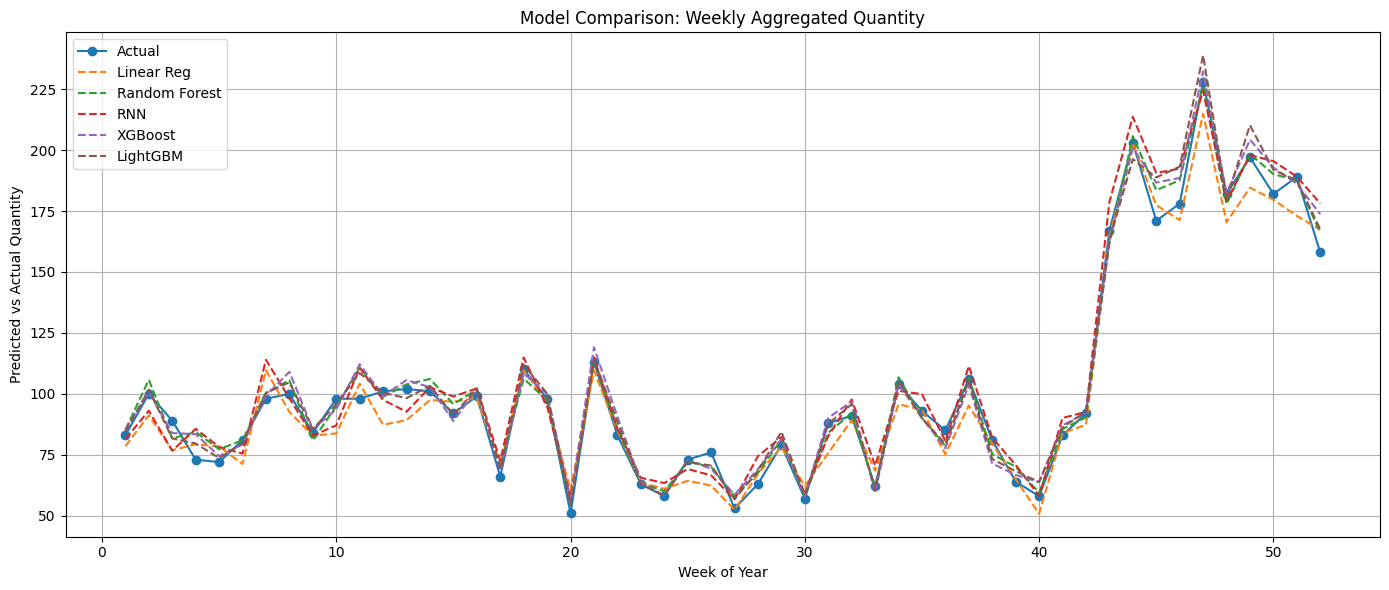

In [334]:
test_df_plot = pd.DataFrame({
    'week': df_encoded['weekofyear'].iloc[split_point:].values,
    'actual': y_test.values,
    'linear': y_pred,
    'rf': y_pred_rf,
    'rnn': y_pred_rnn,
    'xgb': y_pred_xgb,
    'lgb': y_pred_lgb
})

# Group by week
weekly_preds = (
    test_df_plot
    .groupby('week')[['actual','linear','rf','rnn','xgb','lgb']]
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(14,6))
plt.plot(weekly_preds['week'], weekly_preds['actual'], label='Actual', marker='o')
plt.plot(weekly_preds['week'], weekly_preds['linear'], label='Linear Reg', linestyle='--')
plt.plot(weekly_preds['week'], weekly_preds['rf'], label='Random Forest', linestyle='--')
plt.plot(weekly_preds['week'], weekly_preds['rnn'], label='RNN', linestyle='--')
plt.plot(weekly_preds['week'], weekly_preds['xgb'], label='XGBoost', linestyle='--')
plt.plot(weekly_preds['week'], weekly_preds['lgb'], label='LightGBM', linestyle='--')

plt.xlabel("Week of Year")
plt.ylabel("Predicted vs Actual Quantity")
plt.title("Model Comparison: Weekly Aggregated Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [335]:
with open('../models/forecast_model.pkl','wb') as f:
    pickle.dump(rf_model,f)

In [336]:
X.columns

Index(['year', 'weekofyear', 'total_value', 'sentiment', 'category_Furniture',
       'category_Office Supplies', 'region_North', 'region_South',
       'region_West', 'segment_Corporate', 'segment_Small Business'],
      dtype='object')

In [337]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier viewing
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Display top features
feat_imp_df.head(10)


,feature,importance
2,total_value,0.834274
4,category_Furniture,0.057055
5,category_Office Supplies,0.050502
1,weekofyear,0.026061
3,sentiment,0.010859
0,year,0.007210
7,region_South,0.004315
9,segment_Corporate,0.002798
10,segment_Small Business,0.002701
6,region_North,0.002571


13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing


=== R² and RMSE ===
SARIMA - R²: -0.7498  RMSE: 23.48
Prophet - R²: -0.062  RMSE: 18.29


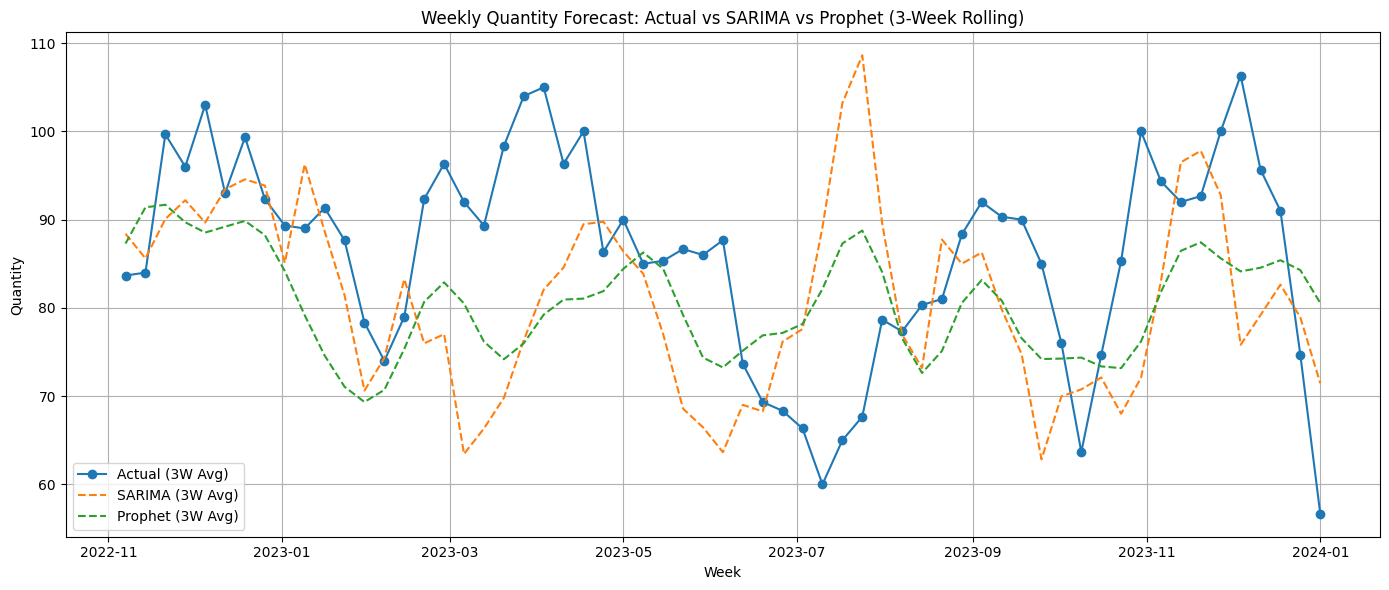

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ========================
# LOAD & AGGREGATE DATA_
# ========================
df = pd.read_csv("../data/cleaned_customer_data.csv")
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['year'] = df['sale_date'].dt.year
df['weekofyear'] = df['sale_date'].dt.isocalendar().week.astype(int)

# Create total_value if not already
if 'total_value' not in df.columns and {'price', 'quantity'}.issubset(df.columns):
    df['total_value'] = df['price'] * df['quantity']

# Weekly aggregation
df['week_date'] = pd.to_datetime(df['sale_date'].dt.strftime('%Y-%U') + '-1', format='%Y-%U-%w')
weekly_data = df.groupby('week_date')['quantity'].sum().reset_index().sort_values('week_date')

# ========================
# TRAIN-TEST SPLIT (70-30)
# ========================
split_point = int(len(weekly_data) * 0.7)
train_df = weekly_data.iloc[:split_point]
test_df = weekly_data.iloc[split_point:]

# ========================
# SARIMA MODEL ON TRAIN SET
# ========================
sarima_model = SARIMAX(train_df.set_index('week_date')['quantity'], order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_result = sarima_model.fit(disp=False)

# Forecast for test period
sarima_forecast = sarima_result.get_forecast(steps=len(test_df))
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# ========================
# PROPHET MODEL
# ========================
prophet_train = train_df.rename(columns={"week_date": "ds", "quantity": "y"})
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(prophet_train)

future = test_df.rename(columns={"week_date": "ds"}).copy()
forecast_prophet = prophet_model.predict(future)

# ========================
# COMBINE PREDICTIONS
# ========================
results_df = pd.DataFrame({
    'week_date': test_df['week_date'],
    'actual': test_df['quantity'].values,
    'sarima': sarima_pred.values,
    'prophet': forecast_prophet['yhat'].values
})

# Add rolling average
results_df['actual_rolling'] = results_df['actual'].rolling(window=3).mean()
results_df['sarima_rolling'] = results_df['sarima'].rolling(window=3).mean()
results_df['prophet_rolling'] = results_df['prophet'].rolling(window=3).mean()

# ========================
# EVALUATE
# ========================
print("=== R² and RMSE ===")
print("SARIMA - R²:", round(r2_score(results_df['actual'], results_df['sarima']), 4),
      " RMSE:", round(np.sqrt(mean_squared_error(results_df['actual'], results_df['sarima'])), 2))
print("Prophet - R²:", round(r2_score(results_df['actual'], results_df['prophet']), 4),
      " RMSE:", round(np.sqrt(mean_squared_error(results_df['actual'], results_df['prophet'])), 2))

# ========================
# PLOT
# ========================
plt.figure(figsize=(14,6))
plt.plot(results_df['week_date'], results_df['actual_rolling'], label='Actual (3W Avg)', marker='o')
plt.plot(results_df['week_date'], results_df['sarima_rolling'], label='SARIMA (3W Avg)', linestyle='--')
plt.plot(results_df['week_date'], results_df['prophet_rolling'], label='Prophet (3W Avg)', linestyle='--')

plt.title("Weekly Quantity Forecast: Actual vs SARIMA vs Prophet (3-Week Rolling)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
